In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 17, 2024
Last modified on May 17, 2024
@Author: Guan-Fu Liu

To analyse the results from ChemEvoIMF that implements the yields from Nomoto et al. (2013).
"""
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '/Users/liuguanfu/Workspace/SAS-21/targets/MRK1216/spex/jupyter/IMF')
import re
import os
import utils
import constants
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
import h5py
from tqdm import tqdm
import time
from matplotlib.gridspec import GridSpec
%matplotlib widget

In [2]:
output_dir = "./outputs/"
solar_set = "Default"
f =  h5py.File(os.path.join(output_dir, "2024-05-21-22-17.h5"), 'r')  # SNIaOn == True

###### Load the yield table used in the simulation  ######
yield_files = {a.split()[0]: f.attrs[a] for a in f.attrs.keys() if 'yield file' in a}
files = {key: h5py.File(value, 'r') for key, value in yield_files.items()}
groups = {key: list(files[key].keys()) for key in files.keys()}  # The available metallicity values in yield table
# The available metallicity values in yield table
Zyield = {key: np.array([float(group.split("=")[1]) for group in groups[key]]) for key in groups.keys()}
ElemNotice = list(f.attrs['Concerned Elements'])
# They should appear in the yield table from AGB+SNcc.
# It should contain H, He and Other.
# The finally selected elements are the intersection of ElemNotice and the elements avaliable in the yield table.
# You may as well not to notice too many elements, which will speed down the calculation.
dfs = { }
ElemIntersect = { }
for key in files.keys():
    dfs[key] = { }
    ElemIntersect[key] = { }
    for group in groups[key]:
        if key == "SNIa":
            dfs[key][group] = pd.DataFrame(files[key][group]['Original'][...])
        else:
            dfs[key][group] = pd.DataFrame(files[key][group]['Interpolated'][...])
        dfs[key][group].loc[:, 'M'] = dfs[key][group].loc[:, 'M'].astype(str)
        dfs[key][group].set_index('M', inplace=True)
        index = dfs[key][group].index
        index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
        # Add the mass of the elements not in ElemNotice to the "Other" element
        if "Other" in dfs[key][group].index:
            dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
        else:
            dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
        ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))

for key in files.keys():
    for group in groups[key]:
        if len(set(ElemNotice)-set(ElemIntersect[key][group]))>0:
            print("The elements you notice but not available in the yield table of %s, %s are" %\
                 (key, group), set(ElemNotice)-set(ElemIntersect[key][group]))
            

YieldsTable = f['Gas/YieldsTable'][()]
if f.attrs['SNIaOn'] == 'Yes':
    print("The yields from SNIa are taken into consideration in the result to be analysed.")
    SNIa = True
elif f.attrs['SNIaOn'] == 'No':
    print("The yields from SNIa are ignored in the result to be analysed.")
    SNIa = False
else:
    raise ValueError("The SNIaOFF attribute should be either 'Yes' or 'No'.")

###### Load the yield table used in the simulation  ######

###### Load the Star group ######

SFH = { }
for key in ['Age', 'SFR', 'TimeBin', 'Mstar']:
    SFH[key] = f['Star/'+key][()]

Mstar = f['Star/Mstar'][()]
SNIaNum = f['Star/SNIaNum'][()]
StarInitElement = f['Star/StarInitElement'][()]
StellarMass = f['Star/StellarMass'][()]
###### Load the Star group ######

###### Load the Gas group ######
GasElement = f['Gas/GasElement'][()]
EjectElement = f['Gas/EjectElement'][()]
YieldsTable = f['Gas/YieldsTable'][()]
ZGas = f['Gas/ZGas'][()]
###### Load the Gas group ######
f.close()

The elements you notice but not available in the yield table of SNIa, Z=0.02 are {'He', 'H'}
The yields from SNIa are taken into consideration in the result to be analysed.


In [3]:
def GetZi2Zj(GasElement, Zi, Zj, solar_set, fill_value=None):
    """
    To get the ratio of the element j to the element i in the solar unit.

    If the mass of the element j at some ages are zero, the ratio of the element j to the element i is set to fill_value.

    Parameters
    ----------
    GasElement : numpy array
        The mass of elements. The shape of GasElement should be (N, 32). Here N is them number of ages, 32 is the number of elements
        (the first and the last elemen are empty and "others", should not be used).
    Zi : str
        The element i. It should be in the list of constants.elem_names, namely, from H to Zn (Z=1, 2, 3, ..., 30).
    Zj : str
        The element j. It should be in the list of constants.elem_names, namely, from H to Zn (Z=1, 2, 3, ..., 30).
    solar_set : str
        The solar abundance set. It should be in the list of constants.abund_tables.keys().
    fill_value : float or None, optional
        The value to fill the ratio of the element j to the element i if the mass of the element j or the element i is zero.
        If it is None, mask the ages where the mass of the element j is zero, which will change the shape of the output.
        If it is a float, it should be a positive number.

    Returns
    -------
    Zi2Zj: dict
        The ratio of the element j to the element i in the solar unit.
        Zi2Zj['%s/%s'%(Zi, Zj)] is the ratio of the element j to the element i, in the solar unit.
        Zi2Zj['[%s/%s]'%(Zi, Zj)] is log10(Zi2Zj['%s/%s'%(Zi, Zj)]).
        Zi2Zj['%s-mask'%Zj] is the mask of the ages where BOTH of the mass of the element j and i is POSITIVE.
    """
    if Zi not in constants.elem_names or Zj not in constants.elem_names:
        print("The element should be in the list of constants.elem_names, which is ", constants.elem_names)
        return None
    if solar_set not in constants.abund_tables.keys():
        print("The solar abundance set should be in the list of constants.abund_tables.keys(), which is ",
               constants.abund_tables.keys())
        return None
    Zi2Zj_solar = constants.abund_tables[solar_set][constants.elem_names.index(Zi)] / \
                   constants.abund_tables[solar_set][constants.elem_names.index(Zj)]
    mask = GasElement[:, constants.elem_names.index(Zj)] > 0
    mask = mask & (GasElement[:, constants.elem_names.index(Zi)] > 0)
    Zi2Zj = { }
    if fill_value is None:
        Zi2Zj['%s/%s'%(Zi, Zj)] = GasElement[mask, constants.elem_names.index(Zi)] / \
                                  GasElement[mask, constants.elem_names.index(Zj)] / Zi2Zj_solar
        Zi2Zj['[%s/%s]'%(Zi, Zj)] = np.log10(Zi2Zj['%s/%s'%(Zi, Zj)])
    else:
        Zi2Zj['%s/%s'%(Zi, Zj)] = np.zeros(len(GasElement))
        Zi2Zj['%s/%s'%(Zi, Zj)][mask] = GasElement[mask, constants.elem_names.index(Zi)] / \
                                        GasElement[mask, constants.elem_names.index(Zj)] / Zi2Zj_solar
        Zi2Zj['%s/%s'%(Zi, Zj)][~mask] = fill_value
        Zi2Zj['[%s/%s]'%(Zi, Zj)] = np.log10(Zi2Zj['%s/%s'%(Zi, Zj)])
    Zi2Zj['%s/%s-mask'%(Zi,Zj)] = mask
    return Zi2Zj

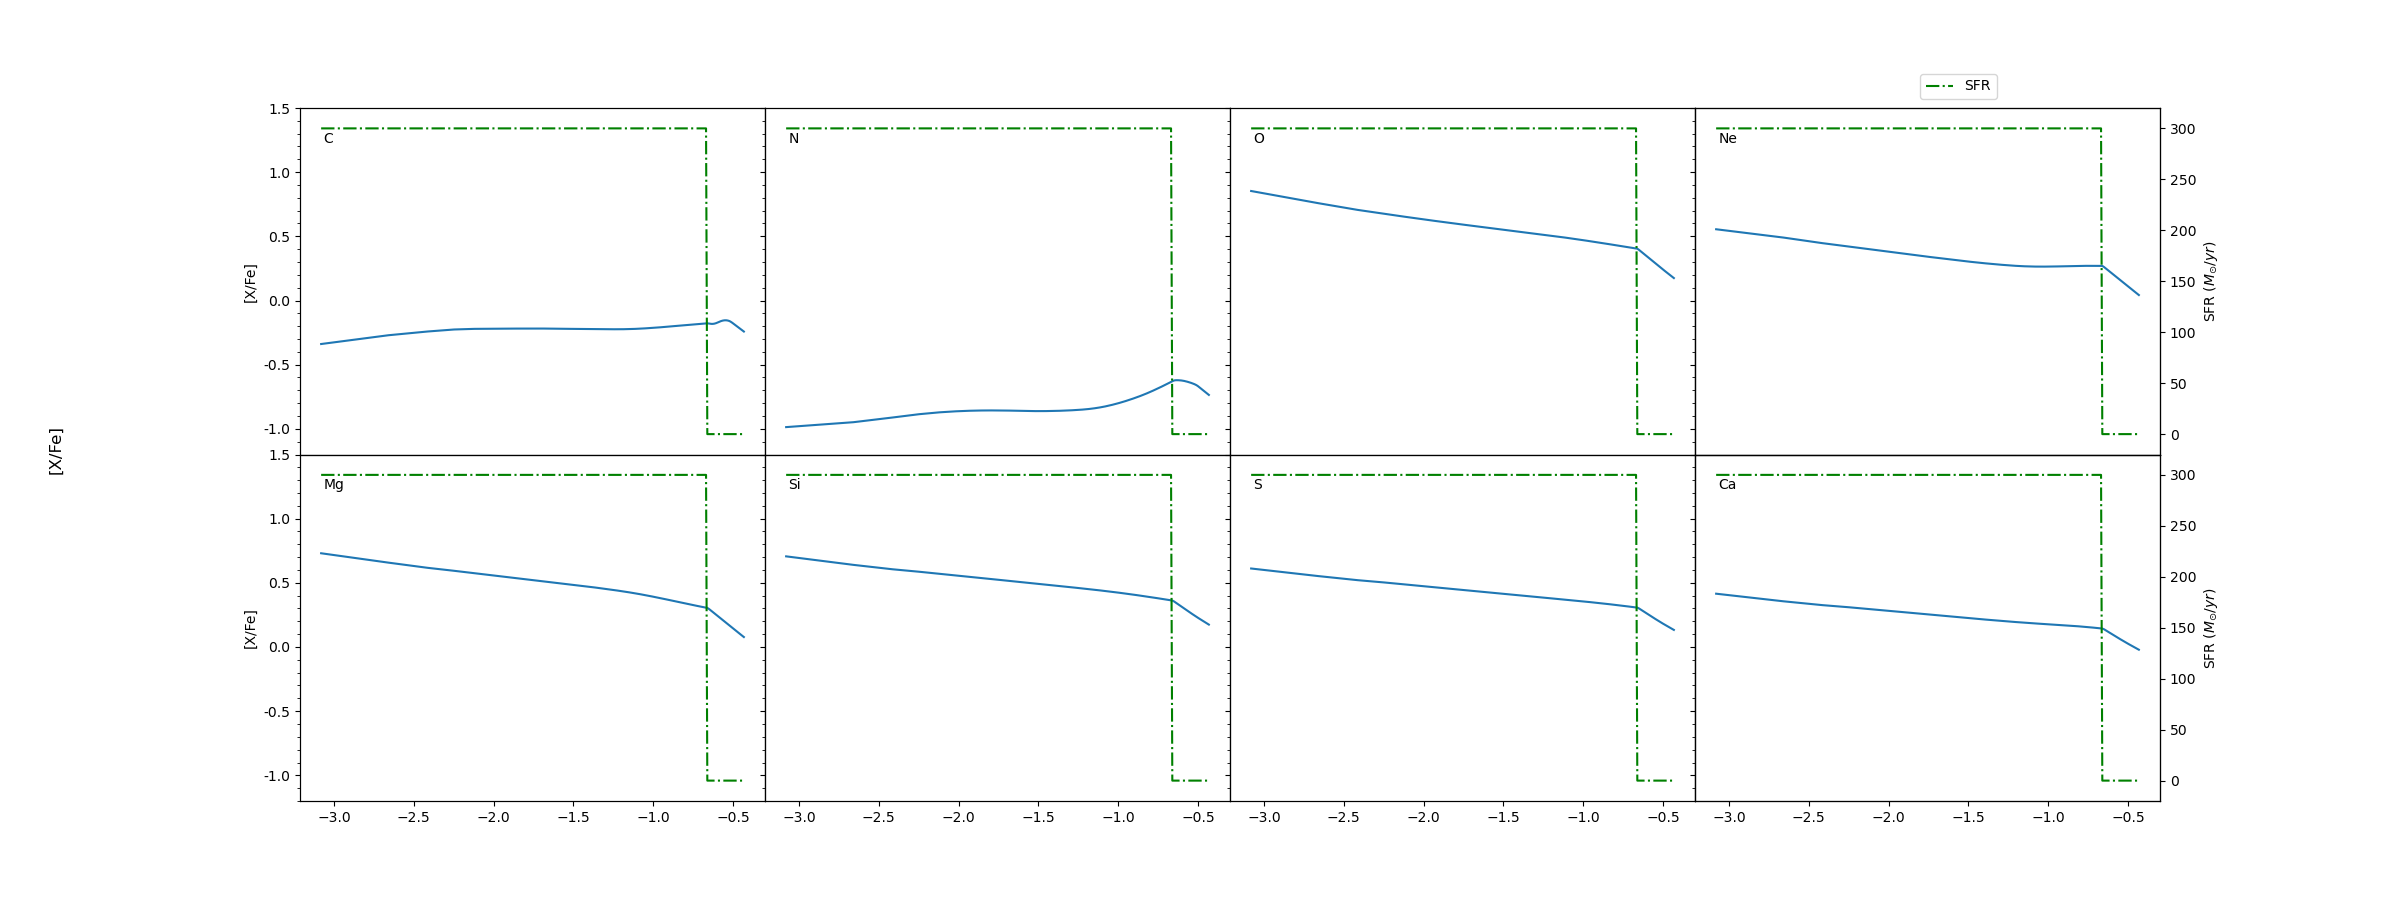

In [4]:
Zi2Zj = { }
Zi2Zj.update(GetZi2Zj(GasElement, "Fe", "H", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "C", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "N", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "O", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Ne", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Mg", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Si", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "S", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Ca", "Fe", solar_set, fill_value=None))

fig = plt.figure(figsize=(6*4, 4.5*2))
gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1], wspace=0, hspace=0)
axes = { }
axes['1'] = fig.add_subplot(gs[0])
axes['2'] = fig.add_subplot(gs[1])
axes['3'] = fig.add_subplot(gs[2])
axes['4'] = fig.add_subplot(gs[3])
axes['5'] = fig.add_subplot(gs[4])
axes['6'] = fig.add_subplot(gs[5])
axes['7'] = fig.add_subplot(gs[6])
axes['8'] = fig.add_subplot(gs[7])

Zi_list = ['C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca']

for i, elem in enumerate(Zi_list):
    ax = axes["%d"%(Zi_list.index(elem)+1)]
    ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj["[%s/Fe]"%elem], '-')
    ax.annotate(elem, xy=(0.05, 0.9), xycoords='axes fraction')
    ax.set_ylim(-1.2, 1.5)
    minor_yticks = np.arange(-1.2, 1.5, 0.1)
    ax.set_yticklabels([])
    ax.set_yticks(minor_yticks, minor=True)
    ax1 = ax.twinx()
    ax1.set_ylim(-20,320)
    line1 = ax1.plot(Zi2Zj["[Fe/H]"], SFH['SFR'][Zi2Zj['Fe/H-mask']], 'g-.')
    ax1.set_yticks([])

major_yticks = np.arange(-1, 1.5+0.5, 0.5)
axes["1"].set_ylabel("[X/Fe]")
axes["1"].set_yticks(major_yticks)
axes["1"].set_yticklabels(major_yticks)
axes["5"].set_ylabel("[X/Fe]")
axes["5"].set_yticks(major_yticks)
axes["5"].set_yticklabels(major_yticks)
major_twin_yticks = np.arange(0, 300+50, 50)
ax1 = axes["4"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)
ax1 = axes["8"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)

fig.legend(line1, ['SFR'], loc=[0.8, 0.89])
fig.supylabel('[X/Fe]')


fig.savefig("ChemEvoIMF_Zi2Zj-N13.pdf")
plt.show()

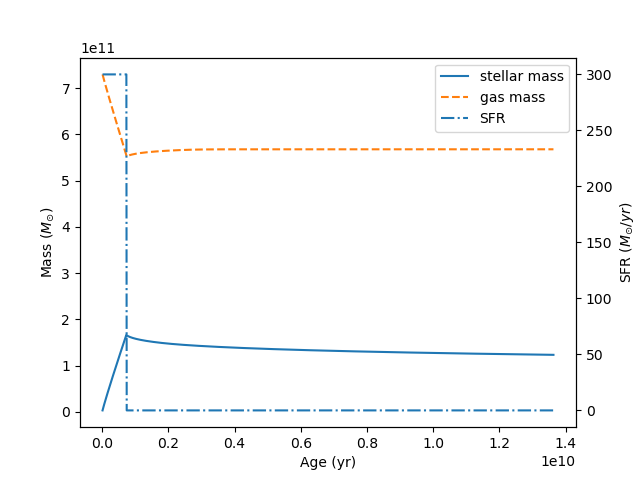

In [5]:
fig, ax = plt.subplots()
line1, = ax.plot(SFH['Age'], StellarMass, '-')
line2, = ax.plot(SFH['Age'], GasElement[:,1:31].sum(axis=1), '--')
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r'Mass ($M_{\odot}$)')
ax1 = ax.twinx()
line3, = ax1.plot(SFH['Age'], SFH['SFR'], '-.')
ax1.set_ylabel(r'SFR ($M_{\odot}/yr$)')
ax.legend([line1, line2, line3], ['stellar mass', 'gas mass', 'SFR'])
fig.savefig("ChemEvoIMF_mass.pdf")

In [6]:
np.diff(StellarMass)

array([ 2.77756877e+09,  2.67012764e+09,  2.60209634e+09, ...,
       -9.71780695e+06, -9.71127953e+06, -3.88268622e+06])

In [7]:
2.18987528e+11 - 2.18995013e+11

-7485000.0

In [8]:
np.diff(SNIaNum)

array([     0.        ,      0.        ,      0.        , ...,
          -22.42820944, -17820.94861099, -11870.17854796])